## ==============Translation with a Sequence to Sequence Network and Attention===============

In [1]:
from io import open
import string
import string
import re
import random
import unicodedata

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: 'SOS', 1: 'EOS'}
        self.n_words = 2
        
    def addSentence(self, sentence):
        for wd in sentence.split(' '):
            self.addWord(wd)
            
    def addWord(self, wd):
        if wd in self.word2index:
            self.word2count[wd] += 1
        else:
            self.word2index[wd] = self.n_words
            self.word2count[wd] = 1
            self.index2word[self.n_words] = wd
            self.n_words += 1
    

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [4]:
def readLangs(lang1, lang2, reverse=False):
    lines = open('classify names with char rnn/data/{}-{}.txt'.format(lang1, lang2), encoding='utf-8').read().strip().split('\n')
    pairs = [[normalizeString(s) for s in line.strip().split('\t')] for line in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lange(lang1)
        output_lang = Lange(lang2)
    return input_lang, output_lang, pairs
    

In [5]:
#只取一部分数据集做demo

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(pair):
    return len(pair[0].strip().split(' ')) < MAX_LENGTH and len(pair[1].strip().split(' ')) < MAX_LENGTH and pair[1].strip().startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
    


In [7]:
def prepareData(lang1, lang2, reverse=False):
    print('=========start prepar date========')
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print('original pairs: ', len(pairs))
    pairs = filterPairs(pairs)
    print('after filter, paris: ', len(pairs))
    
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
        
    print('Lang1/(input): ' + input_lang.name + ', its vocab size: ' + str(input_lang.n_words))
    print('Lang2/(output): ' + output_lang.name + ', its vocab size: ' + str(output_lang.n_words))
    
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

=========start prepar date========
original pairs:  135842
after filter, paris:  10853
Lang1/(input): fra, its vocab size: 4489
Lang2/(output): eng, its vocab size: 2925
['il n est pas encore la .', 'he s not in yet .']


In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embeddings = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        #self.hidden = self.initHidden()
        
    def forward(self, input_, hidden):
        embed = self.embeddings(input_).view(1, 1, -1)
        output = embed
        output, hidden = self.gru(output, hidden)
        
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
             

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.embeddings = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_, hidden):
        embed = self.embeddings(input_).view(1, 1, -1)
        output = F.relu(embed)
        output, hidden = self.gru(output, hidden)
        output = self.linear(output[0])
        output = self.softmax(output)
        return output, hidden
        
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, output_size, hidden_size, max_len=MAX_LENGTH, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.max_len = max_len
        self.dropout_p = dropout_p
        
        self.embeddings = nn.Embedding(output_size, hidden_size)
        self.attn = nn.Linear(hidden_size * 2, max_len)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, input_, hidden, encoder_outs):
        embed = self.embeddings(input_).view(1, 1, -1)
        embed = self.dropout(embed)
        
        attn_wei = F.softmax(self.attn(torch.cat((embed[0], hidden[0]), 1)), dim=1)
        context_vec = torch.bmm(attn_wei.unsqueeze(0), encoder_outs.unsqueeze(0))
        
        attn_combine = self.attn_combine(torch.cat((embed[0], context_vec[0]), 1)).unsqueeze(0)
        gru_in = F.relu(attn_combine)
        
        output, hidden = self.gru(gru_in, hidden)
        out = F.log_softmax(self.out(output[0]), dim=1)
        return out, hidden, attn_wei
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
        
        
    
        

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[w] for w in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    
    return input_tensor, target_tensor

In [12]:
#training

In [13]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, with_attn=True, teacher_learn=False, max_len=MAX_LENGTH):
    encoder.zero_grad()
    decoder.zero_grad()
    
    input_len = input_tensor.size()[0]
    target_len = target_tensor.size()[0]
    
    encoder_hidden = encoder.initHidden()
    encoder_outs = torch.zeros(max_len, encoder.hidden_size, device=device)
    
    loss = 0
    for ei in range(input_len):
        #encoder_out: (seq_len, batch, num_directions * hidden_size) --> (1, 1, hidden_size)
        #encoder_hidden: (num_layers * num_directions, batch, hidden_size) --> (1, 1, hidden_size)
        encoder_out, encoder_hidden = encoder(input_tensor[ei].unsqueeze(0), encoder_hidden)  
        encoder_outs[ei] = encoder_out[0, 0]
        
        #assert encoder_out == encoder_hidden
        
    decoder_input = torch.tensor([[SOS_token]], dtype=torch.long)
    decoder_hidden = encoder_hidden
    
    if teacher_learn:
        for di in range(target_len):
            if with_attn:
                decoder_out, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outs)
            else:
                decoder_out, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoder_input = target_tensor[di]
            loss += criterion(decoder_out, target_tensor[di])

    else:
        for di in range(target_len):
            if with_attn:
                decoder_out, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_outs)
            else:
                decoder_out, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_out.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input!!!
            loss += criterion(decoder_out, target_tensor[di])
            
            if topi == EOS_token:
                break
            
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_len

In [14]:
import math
import time

def asMinutes(s):
    min_ = s // 60
    s -= min_ * 60
    return '{}m, {:.0f}s'.format(min_, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '{} - ({})'.format(asMinutes(s), asMinutes(rs))

In [15]:
def trainIters(encoder, decoder, n_iters, with_attn=True, teacher_learn=False, print_every=1000, plot_every=100, learning_rate=0.03):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()
    
    for i in range(1, n_iters+1):
        loss = train(training_pairs[i-1][0], training_pairs[i-1][1], encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, with_attn=with_attn, teacher_learn=teacher_learn)
        
        print_loss_total += loss
        plot_loss_total += loss
        
        if i % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('{} ({} {:.2%}) {:.4}'.format(timeSince(start, i / n_iters), i, i / n_iters, print_loss_avg))
    
        if i % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    plotShow(plot_losses)

In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def plotShow(losses):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(losses)
    
    

In [17]:
###attn_decoder && non_teacher_learning

1.0m, 54s - (36.0m, 14s) (2000 5.00%) 3.164
3.0m, 49s - (34.0m, 17s) (4000 10.00%) 2.705
5.0m, 43s - (32.0m, 26s) (6000 15.00%) 2.472
7.0m, 38s - (30.0m, 31s) (8000 20.00%) 2.334
9.0m, 33s - (28.0m, 40s) (10000 25.00%) 2.238
11.0m, 28s - (26.0m, 45s) (12000 30.00%) 2.144
13.0m, 24s - (24.0m, 53s) (14000 35.00%) 2.055
15.0m, 21s - (23.0m, 1s) (16000 40.00%) 2.008
17.0m, 16s - (21.0m, 6s) (18000 45.00%) 1.926
19.0m, 13s - (19.0m, 13s) (20000 50.00%) 1.876
21.0m, 10s - (17.0m, 19s) (22000 55.00%) 1.829
23.0m, 7s - (15.0m, 24s) (24000 60.00%) 1.793
25.0m, 4s - (13.0m, 30s) (26000 65.00%) 1.782
26.0m, 59s - (11.0m, 34s) (28000 70.00%) 1.74
28.0m, 56s - (9.0m, 39s) (30000 75.00%) 1.72
30.0m, 51s - (7.0m, 43s) (32000 80.00%) 1.736
32.0m, 48s - (5.0m, 47s) (34000 85.00%) 1.717
34.0m, 44s - (3.0m, 52s) (36000 90.00%) 1.648
36.0m, 40s - (1.0m, 56s) (38000 95.00%) 1.678
38.0m, 37s - (0.0m, 0s) (40000 100.00%) 1.621


<Figure size 432x288 with 0 Axes>

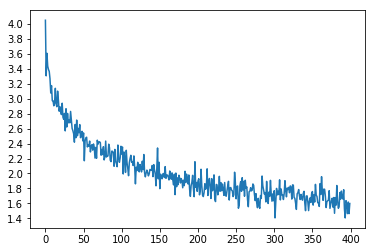

In [18]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(output_lang.n_words, hidden_size).to(device)

trainIters(encoder1, attn_decoder1, n_iters=40000, print_every=2000)

In [19]:
###ori decoder && non_teacher_learn

1.0m, 42s - (32.0m, 19s) (2000 5.00%) 3.148
3.0m, 27s - (31.0m, 1s) (4000 10.00%) 2.755
5.0m, 13s - (29.0m, 32s) (6000 15.00%) 2.496
6.0m, 59s - (27.0m, 57s) (8000 20.00%) 2.357
8.0m, 46s - (26.0m, 18s) (10000 25.00%) 2.207
10.0m, 33s - (24.0m, 36s) (12000 30.00%) 2.062
12.0m, 19s - (22.0m, 53s) (14000 35.00%) 1.927
14.0m, 9s - (21.0m, 13s) (16000 40.00%) 1.92
15.0m, 56s - (19.0m, 28s) (18000 45.00%) 1.811
17.0m, 43s - (17.0m, 43s) (20000 50.00%) 1.777
19.0m, 30s - (15.0m, 57s) (22000 55.00%) 1.743
21.0m, 17s - (14.0m, 12s) (24000 60.00%) 1.757
23.0m, 5s - (12.0m, 26s) (26000 65.00%) 1.587
24.0m, 52s - (10.0m, 39s) (28000 70.00%) 1.587
26.0m, 39s - (8.0m, 53s) (30000 75.00%) 1.595
28.0m, 27s - (7.0m, 7s) (32000 80.00%) 1.507
30.0m, 15s - (5.0m, 20s) (34000 85.00%) 1.545
32.0m, 2s - (3.0m, 34s) (36000 90.00%) 1.431
33.0m, 51s - (1.0m, 47s) (38000 95.00%) 1.44
35.0m, 39s - (0.0m, 0s) (40000 100.00%) 1.379


<Figure size 432x288 with 0 Axes>

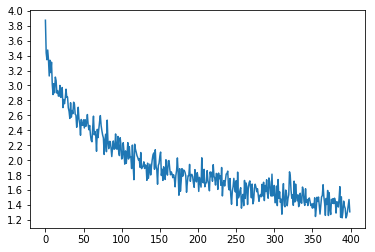

In [20]:
hidden_size = 128
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
ori_decoder2 = DecoderRNN(output_lang.n_words, hidden_size).to(device)

trainIters(encoder2, ori_decoder2, n_iters=40000, print_every=2000, with_attn=False)

In [21]:
###ori decoder && teacher_learn

1.0m, 51s - (35.0m, 17s) (2000 5.00%) 3.044
3.0m, 41s - (33.0m, 12s) (4000 10.00%) 2.358
5.0m, 31s - (31.0m, 18s) (6000 15.00%) 2.087
7.0m, 21s - (29.0m, 23s) (8000 20.00%) 1.873
9.0m, 11s - (27.0m, 33s) (10000 25.00%) 1.75
11.0m, 1s - (25.0m, 41s) (12000 30.00%) 1.596
12.0m, 51s - (23.0m, 51s) (14000 35.00%) 1.534
76.0m, 33s - (114.0m, 50s) (16000 40.00%) 1.393
78.0m, 25s - (95.0m, 50s) (18000 45.00%) 1.339
80.0m, 15s - (80.0m, 15s) (20000 50.00%) 1.286
82.0m, 6s - (67.0m, 11s) (22000 55.00%) 1.176
83.0m, 59s - (55.0m, 59s) (24000 60.00%) 1.164
85.0m, 51s - (46.0m, 14s) (26000 65.00%) 1.079
87.0m, 47s - (37.0m, 37s) (28000 70.00%) 1.039
89.0m, 38s - (29.0m, 53s) (30000 75.00%) 0.9728
91.0m, 28s - (22.0m, 52s) (32000 80.00%) 0.9242
93.0m, 18s - (16.0m, 28s) (34000 85.00%) 0.9104
95.0m, 8s - (10.0m, 34s) (36000 90.00%) 0.8939
96.0m, 58s - (5.0m, 6s) (38000 95.00%) 0.8015
98.0m, 47s - (0.0m, 0s) (40000 100.00%) 0.8037


<Figure size 432x288 with 0 Axes>

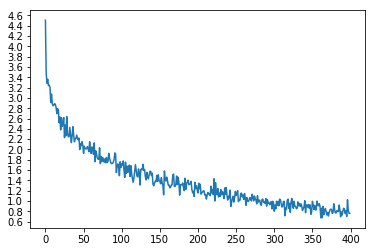

In [22]:
hidden_size = 128
encoder3 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
ori_decoder3 = DecoderRNN(output_lang.n_words, hidden_size).to(device)

trainIters(encoder3, ori_decoder3, n_iters=40000, print_every=2000, with_attn=False, teacher_learn=True)

In [27]:
def evaluate(encoder, decoder, sentence, with_attn=True, max_len=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_len = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        
        encoder_outputs = torch.zeros(max_len, encoder.hidden_size, device=device)
        for ei in range(input_len):
            encoder_out, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_out[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        
        decoded_words = []
        decoder_attns = torch.zeros(max_len, max_len)
        
        for di in range(max_len):
            if with_attn:
                decoder_out, decoder_hidden, decoder_attn = decoder(decoder_input, decoder_hidden, encoder_outputs)
                decoder_attns[di] = decoder_attn.data
            else:
                decoder_out, decoder_hidden = decoder(decoder_input, decoder_hidden)
            
            topv, topi = decoder_out.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
                
            decoder_input = topi.squeeze().detach()
        if with_attn:  
            return decoded_words, decoder_attns[:di + 1]
        else:
            return decoded_words
                

In [28]:
def evaluateRandomly(encoder, decoder, with_attn=True, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('> ', pair[0])
        print('= ', pair[1])
        if with_attn:
            outs , attn = evaluate(encoder, decoder, pair[0])
        else:
            outs = evaluate(encoder, decoder, pair[0], with_attn=False)
        
        print('< ', ' '.join(outs))
        print('')

In [31]:
def compareRes(model_1, model_2, model_3, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('===========' + str(i) + '=============')
        print('input--> ', pair[0])
        print('gold--> ', pair[1])
        outs_1, _ = evaluate(model_1[0], model_1[1], pair[0])
        print('attn_decoder&&non_teacher_learning-->', ' '.join(outs_1))
        outs_2 = evaluate(model_2[0], model_2[1], pair[0], with_attn=False)
        print('ori_decoder&&non_teacher_learning-->', ' '.join(outs_2))
        outs_3 = evaluate(model_3[0], model_3[1], pair[0], with_attn=False)
        print('ori_decoder&&teacher_learning-->', ' '.join(outs_3))

In [32]:
compareRes((encoder1, attn_decoder1), (encoder2, ori_decoder2), (encoder3, ori_decoder3), n=15)

===========0=============
input-->  il semble probable qu il echoue .
gold-->  he is not likely to succeed .
attn_decoder&&non_teacher_learning--> he s likely likely likely he s . <EOS>
ori_decoder&&non_teacher_learning--> he is likely it it <EOS>
ori_decoder&&teacher_learning--> he is likely to come . <EOS>
===========1=============
input-->  je vais rentrer chez moi demain .
gold-->  i m going back home tomorrow .
attn_decoder&&non_teacher_learning--> i am going to leave tomorrow tomorrow <EOS>
ori_decoder&&non_teacher_learning--> i m going home tomorrow tomorrow . <EOS>
ori_decoder&&teacher_learning--> i m going back home tomorrow . <EOS>
===========2=============
input-->  je suis desolee de t avoir blesse .
gold-->  i m sorry i hurt you .
attn_decoder&&non_teacher_learning--> i m sorry i as you you . <EOS>
ori_decoder&&non_teacher_learning--> i m sorry i yelled you . <EOS>
ori_decoder&&teacher_learning--> i m sorry i hurt you . <EOS>
===========3=============
input-->  il est etud

In [33]:
#分析：
#1.对于训练集的loss来说，都还没有到收敛，因为太慢了，可以拿到服务器上面跑
#2.loss: attn > non_attn > teacher_learning; 而且 non_attn 比 attn收敛更快；尴尬，attn起了副作用？也说不好：一是没有训练完全，二是句子太短，
#最长为10，可能还没轮到attn的发挥
#3.teacher_learning的loss显著较小，因为强行输入的是按gold输入的，肯定会小一些，但是！！！最后的case看，也明显好，说好的不稳定呢？
#需要查些资料验证下；
#4.attn到底学到了东西吗？下面可视化看下：

In [37]:
def showAttention(input_, output_, attns):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attns.numpy(), cmap='bone')
    cax = ax.matshow(attns.numpy())
    fig.colorbar(cax)
    
    ax.set_xticklabels([''] + input_.strip().split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_.strip().split(' ') + ['<EOS>'])
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    
def evalAndShowAttn(input_sent):
    output_wds, output_attns = evaluate(encoder1, attn_decoder1, input_sent)
    print('input: ', input_sent)
    print('output: ', ' '.join(output_wds))
    showAttention(input_sent, ' '.join(output_wds), output_attns)
    

input:  il semble probable qu il echoue .
output:  he s likely likely win she game . . <EOS>


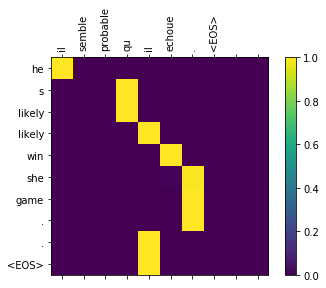

In [38]:
evalAndShowAttn('il semble probable qu il echoue .')

input:  je suis detendu .
output:  i m stubborn . . <EOS>


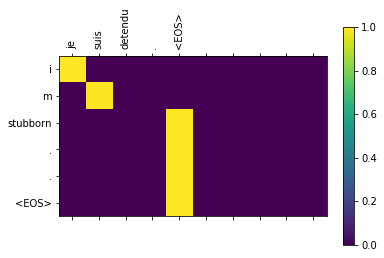

In [40]:
evalAndShowAttn('je suis detendu .')

input:  tu n es pas rationnelle .
output:  you re not singer . <EOS>


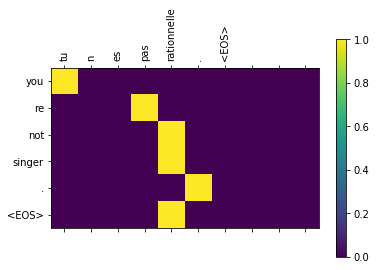

In [41]:
evalAndShowAttn('tu n es pas rationnelle .')

input:  je suis contente que ca te rende heureuse .
output:  i m happy happy to you happy <EOS>


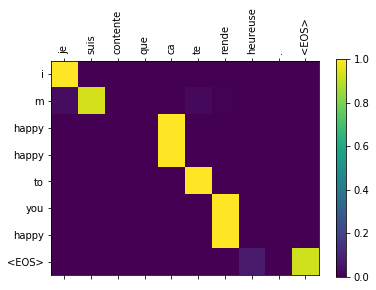

In [42]:
evalAndShowAttn('je suis contente que ca te rende heureuse .')

In [43]:
#感觉并不是很好

In [44]:
#待到服务器上敞开跑跑在分析吧